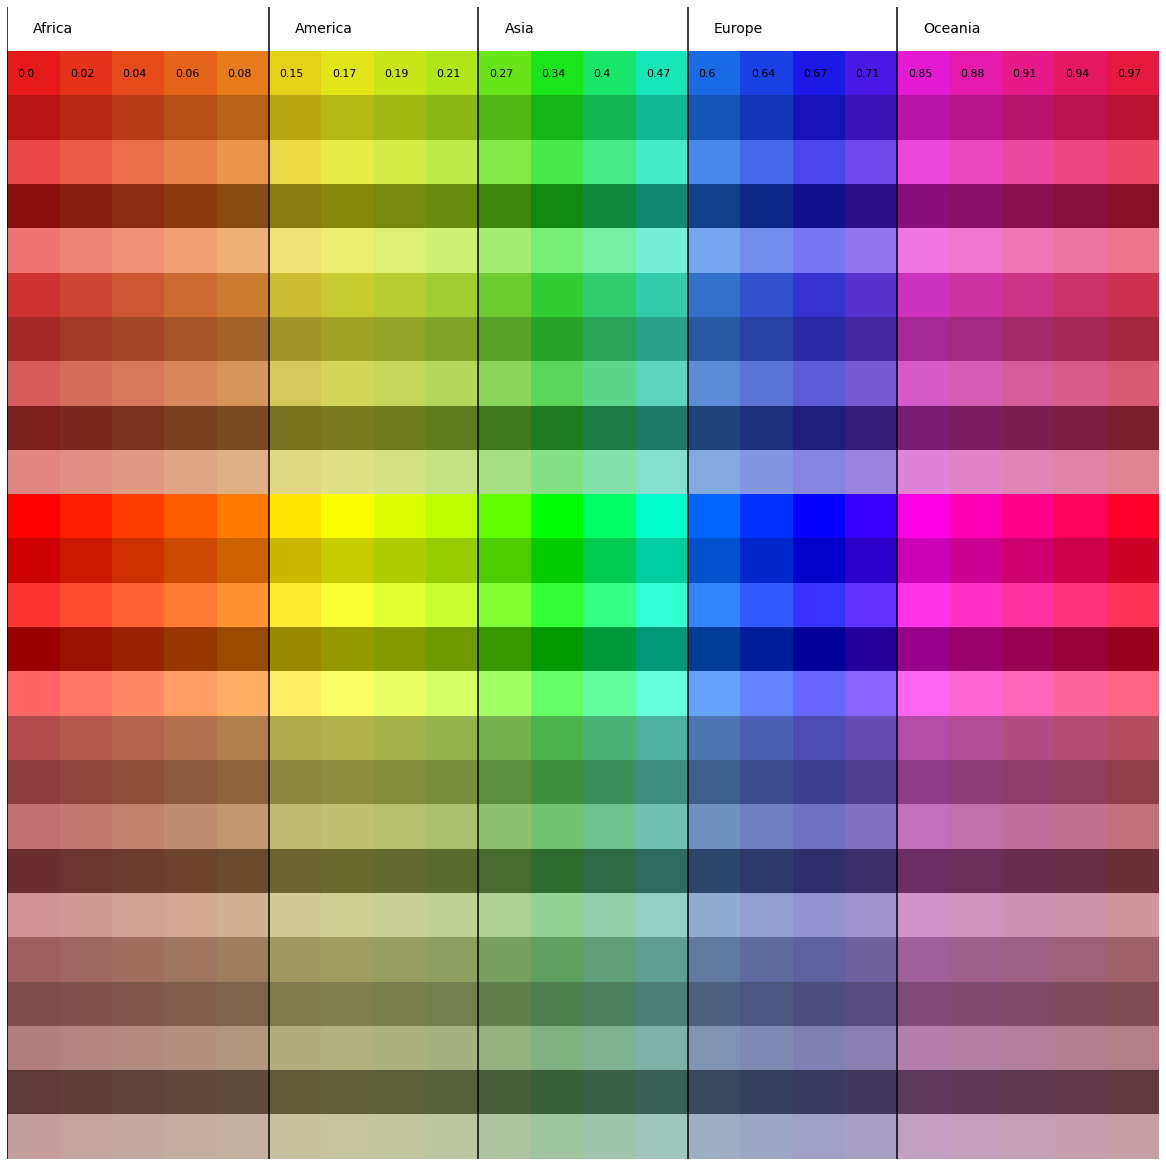

In [1]:
import csv
import webcolors 
import colorsys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatch




def gen_gco_palette(h_value,h_area_span, l_value, s_value):


    base_arr =[[1, "Africa", 5], [2, "America", 4], [4, "Asia",4], [5, "Europe",4],[6, "Oceania",5]]

    df = pd.DataFrame(columns=["continent_code","continent_label", "area_code", "color_continent", "color_area", "color_hex", "color_code"])


    df_row = 0
    area_code = 0

    nb_cont = 0

    for  code, label, subs in base_arr:

        h_base = h_value[nb_cont]
        
        #create loop for each area
        color_continent = colorsys.hls_to_rgb(h_base, l_value[0], s_value[0])
        color_continent = [int(x*255.0) for x in color_continent]
        color_continent = webcolors.rgb_to_hex(color_continent)

        h_span = h_area_span[nb_cont]
        nb_cont +=1 
        h_base_area = h_base
        
        
        for i_area in range(subs):

            
            color_area = colorsys.hls_to_rgb(h_base_area, l_value[0], s_value[0])
            color_area = [int(x*255.0) for x in color_area]
            color_area = webcolors.rgb_to_hex(color_area)
            area_code += 1
            color_code= 1
            for s_temp in s_value:
                for l_temp in l_value:
                    color_temp = colorsys.hls_to_rgb(h_base_area, l_temp, s_temp)
                    color_temp = [int(x*255.0) for x in color_temp]
                    color_temp = webcolors.rgb_to_hex(color_temp)
                    df.at[df_row, 'continent_code'] = code
                    df.at[df_row, 'continent_label'] = label
                    df.at[df_row, 'area_code'] = area_code
                    df.at[df_row, 'color_continent'] = color_continent
                    df.at[df_row, 'color_area'] = color_area
                    df.at[df_row, 'color_code'] = color_code
                    df.at[df_row, 'color_hex'] = color_temp
                    df.at[df_row, 'hue'] = round(h_base_area,2)
                    color_code+=1
                    df_row+=1

            h_base_area = h_base_area + h_span

            


    fig = plt.figure(figsize=[16, 16])
    ax = fig.add_axes([0, 0, 1, 1])



    for index, row in df.iterrows():


        
        plot_x = row['area_code']-1
        plot_y = 25-row['color_code']

        r1 = mpatch.Rectangle((plot_x, plot_y), 1, 1, color=row['color_hex'])
        ax.add_patch(r1)
        # ax.add_patch(r2)

        if row['color_hex'] ==  row['color_continent']:
             ax.axvline(plot_x, color='k')
             ax.text(plot_x+0.5, 25.5,  row['continent_label'], va='center', fontsize=14)

        if row['color_hex'] ==  row['color_area']:
            ax.text(plot_x+0.2, plot_y+0.5,  row['hue'], va='center', fontsize=11)


        

    ax.set_xlim(0, 22)
    ax.set_ylim(0, 26)
    ax.axis('off')



    return df, plt



#continent color 

# #continent code, continent_label, nb_area per continent


hue_continent = [0,0.15,0.27,0.60,0.85]
hue_area_span = [0.02,0.02,0.065,0.035,0.03]
saturation_value = [0.8,0.6,1,0.4,0.25]
lightness_value =  [0.5,0.4,0.6,0.3,0.7]

df_palette, plot_palette = gen_gco_palette(hue_continent,hue_area_span,lightness_value,saturation_value)
plot_palette.show()


